In [31]:
import pandas as pd

data = pd.read_csv('../../data/processed/import_declarations_intermax_daily.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data

,Abgabe
Date,
2017-01-02,439.79
2017-01-03,2107.94
2017-01-04,215.37
2017-01-05,0.00
2017-01-06,0.00
...,...
2019-11-08,1265.71
2019-11-09,0.00
2019-11-10,0.00


In [32]:
data['Abgabe_avg'] = data['Abgabe'].rolling(window=30).mean()

data = data.dropna(subset=['Abgabe_avg'])

In [33]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Abgabe_avg'])
print("Test statistic = {:.4f}".format(result[0])) 
print("p-value = {:.4f}".format(result[1]))

Test statistic = -3.4735
p-value = 0.0087


In [34]:
from data_preperation import check_stationarity

check_stationarity(data.Abgabe_avg)

'Stationary	 p-value:0.008693770550072005 	 lags:21


('Stationary', 0.008693770550072005)

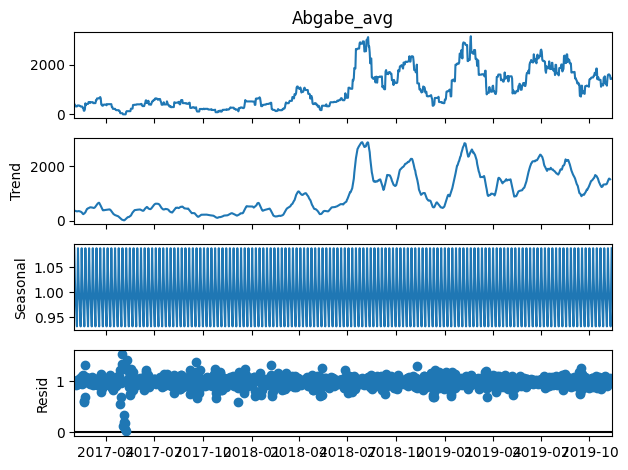

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposed = seasonal_decompose(data.Abgabe_avg, model='multiplicative') 
decomposed.plot(); plt.show()

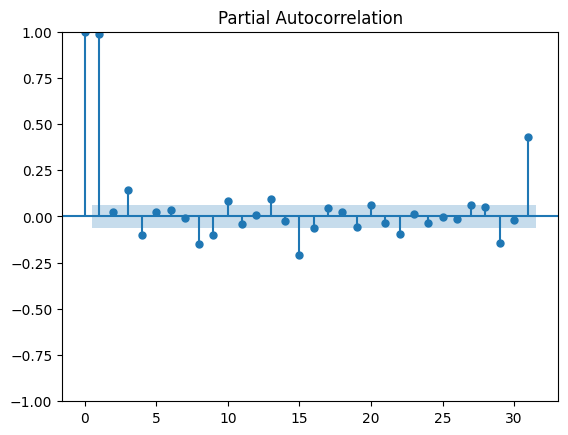

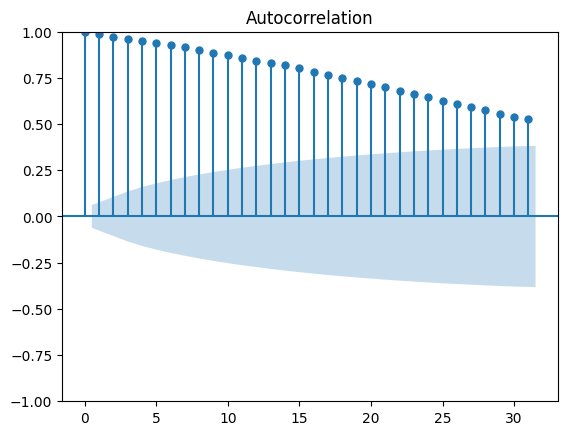

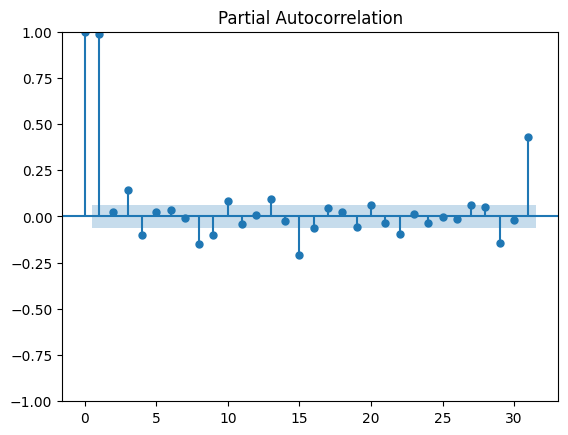

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data.Abgabe_avg)
plot_pacf(data.Abgabe_avg)

In [37]:
from data_preperation import split_data

train, test = split_data(data.Abgabe_avg, test_split=0.80)

train: 812 , test: 204


In [38]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 2, 1))
result = model.fit()

/home/stefaneissler/customsfee_forecasting/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/stefaneissler/customsfee_forecasting/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/stefaneissler/customsfee_forecasting/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Abgabe_avg   No. Observations:                  812
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -5022.726
Date:                Fri, 22 Mar 2024   AIC                          10051.452
Time:                        12:09:23   BIC                          10065.543
Sample:                    01-31-2017   HQIC                         10056.862
                         - 04-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0135      0.029     -0.468      0.640      -0.070       0.043
ma.L1         -0.9983      0.007   -135.136      0.000      -1.013      -0.984
sigma2      1.411e+04    252.613     55.854      0.000    1.36e+04    1.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              9420.43
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              15.17   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

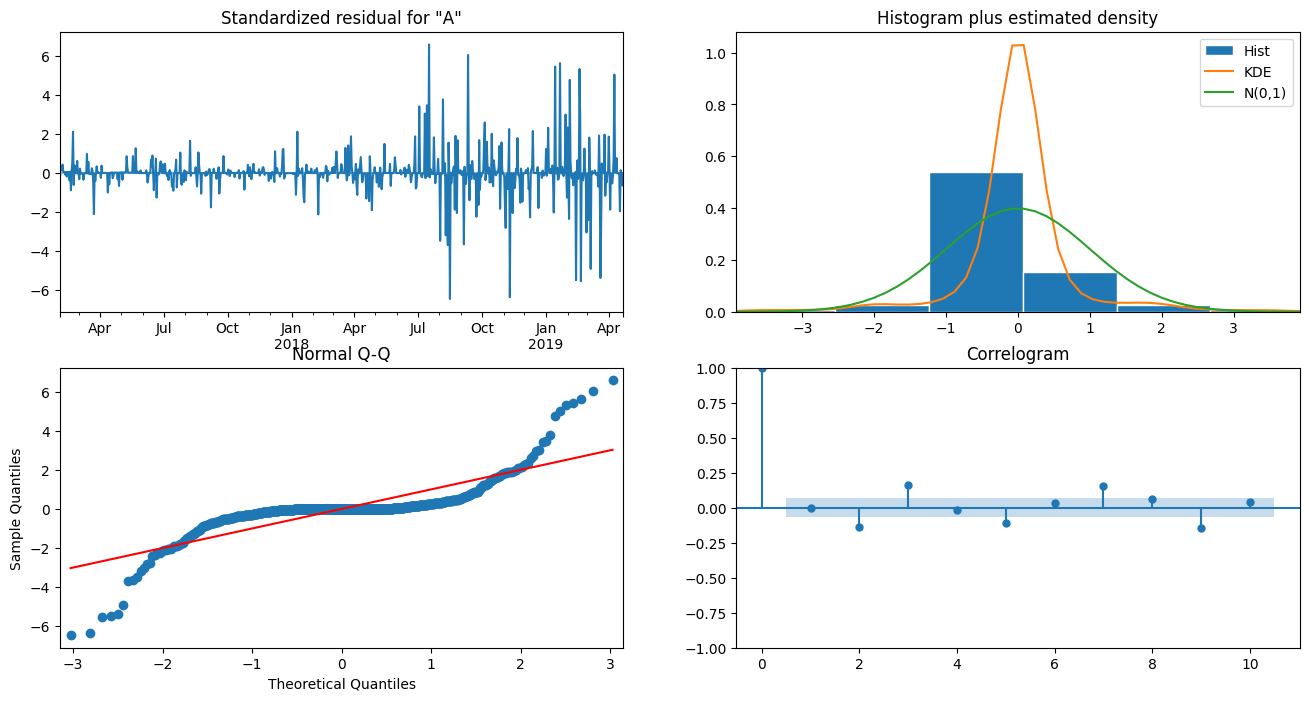

In [40]:
result.plot_diagnostics(figsize=(16, 8))
plt.show()


In [41]:
forecast = result.forecast(steps=len(test))


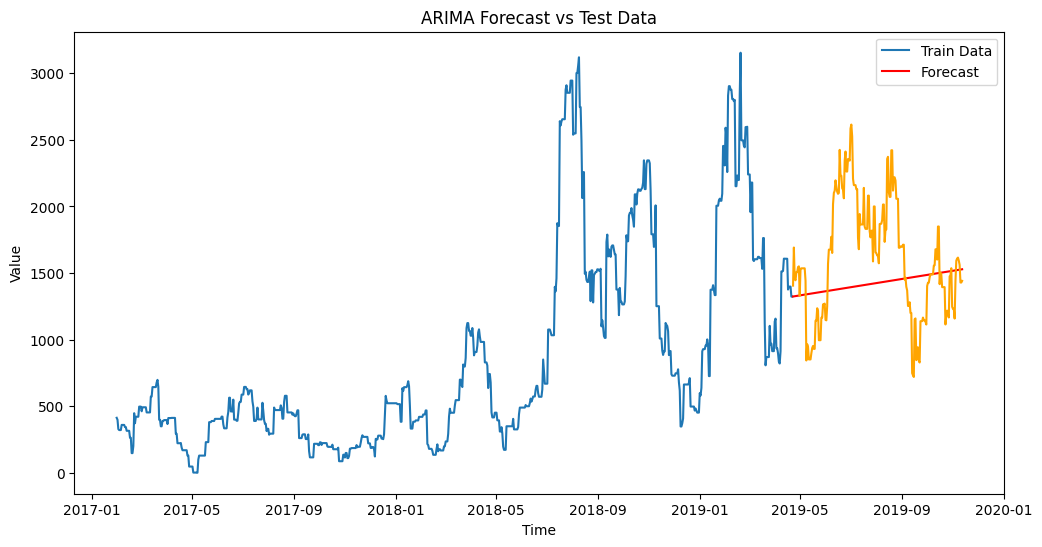

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.plot(test, color='orange')
plt.title('ARIMA Forecast vs Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

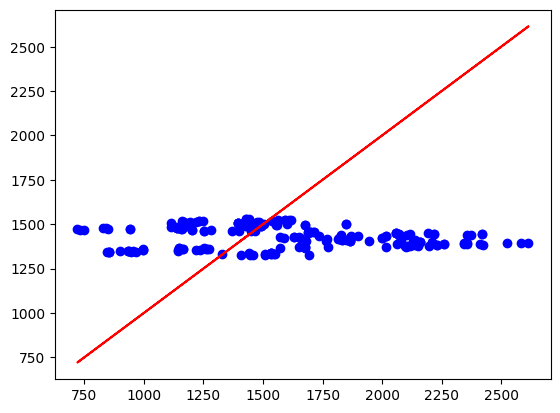

In [43]:
plt.scatter(test, forecast, color='blue', label='Predictions')
plt.plot(test, test, color='red')

In [44]:
from data_preperation import get_validation_matrix

validation_results = get_validation_matrix(forecast, test, train)
validation_results['name'] = 'ARIMA'
validation_results

{'MAE': 394.08637165350433,
 'MSE': 235230.90694454144,
 'meanMASE': 8.020504847186732,
 'r2': -0.21836910308764335,
 'Forecast Bias': -181.00591098110394,
 'Forecast Accuracy (%)': 12.468043085227478,
 'name': 'ARIMA'}

In [45]:
from data_preperation import save_metrics_to_csv

save_metrics_to_csv(validation_results)

Metrics saved to metrics.csv
